# Projet numérique de Science des Données 2025

__Binôme numéro 8 -- DE FERRAN Louise et PÉRONNE Joséphine__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

## Librairies usuelles

In [1]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [2]:
df_train = pd.read_csv('data/donnees_entrainement.csv')
df_train.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [3]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

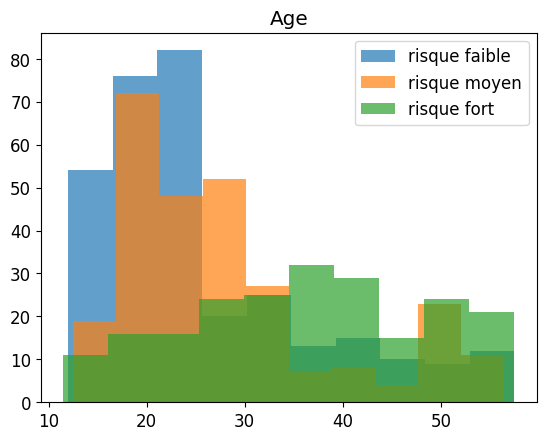

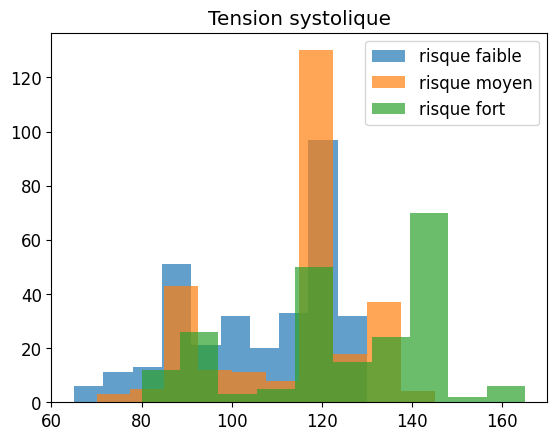

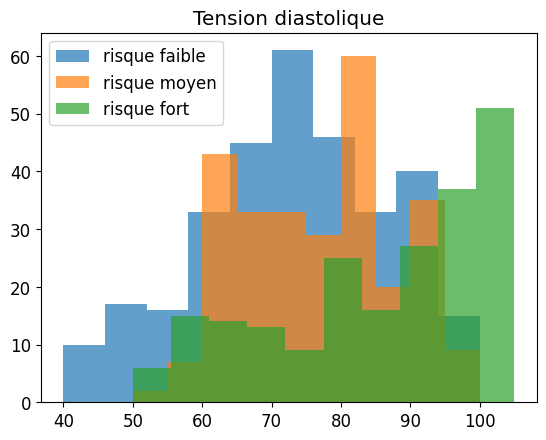

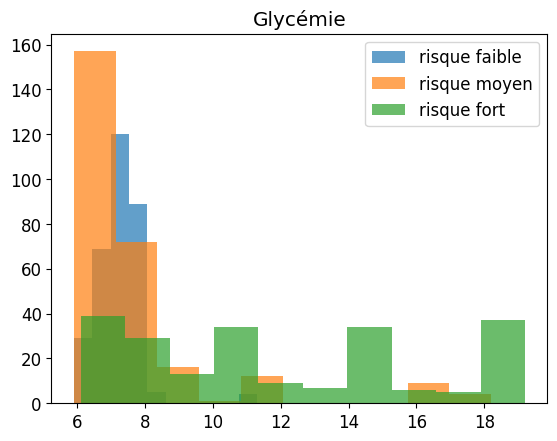

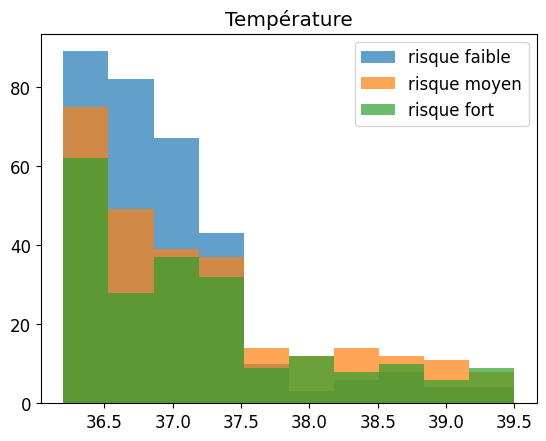

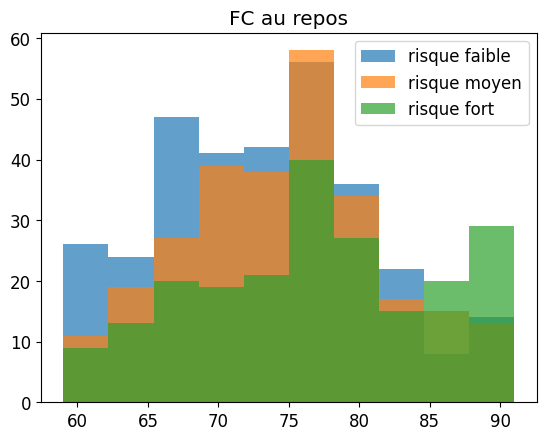

In [4]:
for col in df_train.drop('Risque', axis=1).columns:
    plt.figure()
    plt.hist(df_train[df_train['Risque']==0][col], label='risque faible', alpha= 0.7)
    plt.hist(df_train[df_train['Risque']==1][col], label='risque moyen', alpha= 0.7)
    plt.hist(df_train[df_train['Risque']==2][col], label='risque fort', alpha= 0.7)
    plt.title(col)
    plt.legend()
    plt.show()

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

En ce qui concerne l'âge, les valeurs semblent cohérentes : le risque faible est cantonné entre 12 et 25 ans, sachant que pour les âges inférieurs l'absence de données s'explique logiquement par l'absence totale de risque. Au-delà de 25 ans, le risque devient moyen, surtout jusqu'à 35 ans. Le risque fort est relativement réparti uniformément, avec un pic entre 35 et 45 ans. 

En ce qui concerne la tension systolique, le risque semble fort pour une tension élevée ce qui est cohérent, mais le reste des valeurs prises n'est pas très explicatif, avec par exemple un pic notable de risque moyen à 120mmHg (ainsi que dans une moindre mesure du risque faible et fort) sans explication évidente apparente. De même, la glycémie ne semble pas très explicative, avec une concentration relativement uniforme de tous les risques autour de 6-8mmol/L, ainsi de façon encore plus accentuée que la température, avec des concentrations de tous les risques autour des températures normales du corps humain. 

Sans connaissance en médecine on ne peut pas trancher mais la tension diastolique semble également un relativement bon indicateur avec une grande concentration des risque faibles, moyens et élevés autour de points relativement séparés, même s'il y a un mélange des données. Il semble donc en tout cas intéressant de le prendre en compte. 

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

En n'utilisant que ces 6 variables, ce sera à priori difficile de prédire le risque de grossesse, car il n'y a pas de tendance très marquée sur une variable distinguant les risques fort et moyen du risque faible. Cependant on peut espérer qu'en combinant ces 6 variables, avec de bons coefficients, on puisse finalement prédire le risque. En effet, certaines variables semblent tout de même corrélées au risque de grossesse, comme la tension diastolique qui est plus élevée pour un risque fort ou la glycémie plus faible pour des risques faible ou moyen, tandis que d'autres semblent ne pas l'être du tout, comme la température.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

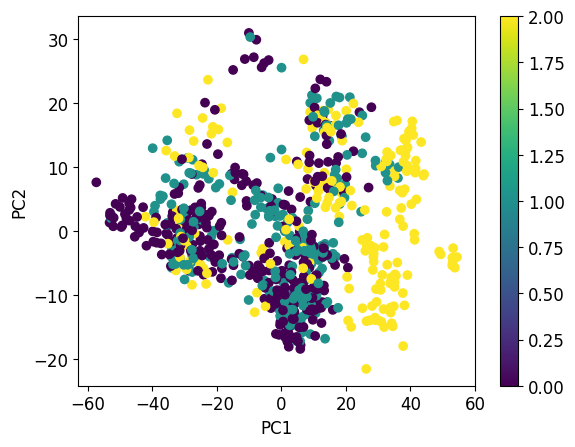

In [5]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)
pca.fit(X_train)

X_projected = pca.transform(X_train)

plt.scatter(X_projected[:,0], X_projected[:,1], c=df_train['Risque'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

#print(pca.components_)

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

Ces 2 composantes nous donnent déjà des informations intéressantes : 
* les risques moyen et faible sont plus occurents pour de faible composante 1 et 2.
* le risque fort est plus occurent pour une grande composante 1, et ne semble pas dépendre de la composante 2. 

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

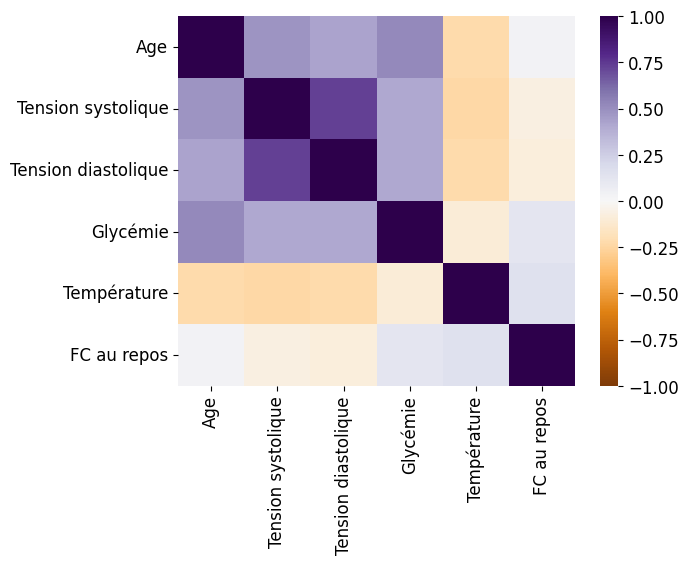

In [6]:
import seaborn as sns
'''
import scipy.stats as st
r, pval = st.pearsonr(X_projected[:,0],X_projected[:,1])
print(f"{r:.2f},{pval:.2e}")
'''

corr_matrix = df_train.drop('Risque', axis = 1).corr()

sns.heatmap(corr_matrix, vmin=-1, vmax=1, center=0, cmap='PuOr')
plt.show()

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

Grâce au gradient de couleurs, on peut identifier quelles données sont corrélées ; il s'agit ici de la tension systolique et la tension diastolique. Ainsi pour faire l'étude, on peut ne conserver qu'une seule de ces deux données, et ainsi réduire la dimension.

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [7]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

In [8]:
TP = df_train_risk_vs_norisk[df_train_risk_vs_norisk['Risque']==1]['Age'].count()
accuracy = TP/800
print(f"L'accuracy est de {accuracy}")

L'accuracy est de 0.605


### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

Ce critère d'évaluation prend aussi en compte les cas négatifs, en plus des cas positifs. En effet, on souhaite aussi que le classifieur identifie correctement les cas négatifs, et pas uniquement les cas positifs.

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

La phase d'apprentissage consiste dans le stockage des vecteurs $\vec{x}$ et des étiquettes de chaque point du jeu d'apprentissage.

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

X_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk.drop('Risque', axis=1))
# y_train_risk_vs_norisk

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train_risk_vs_norisk, y_train_risk_vs_norisk)

y_pred_kppv = neigh.predict(X_train_risk_vs_norisk)
print(f"La précision équilibrée du plus proche voisin est :{metrics.balanced_accuracy_score(y_train_risk_vs_norisk, y_pred_kppv):.4g}")


La précision équilibrée du plus proche voisin est :1


### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

c:\miniconda\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


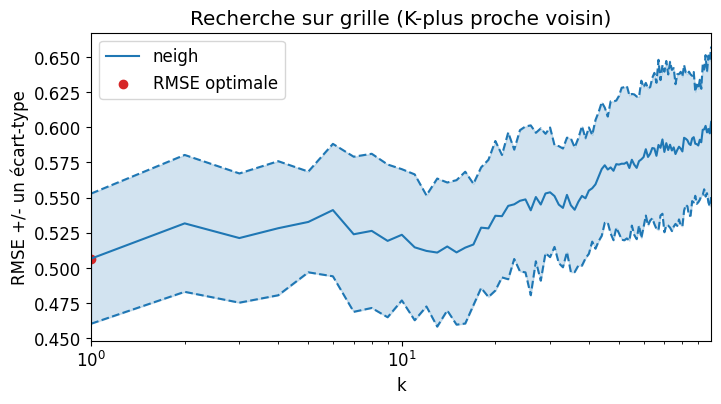

In [20]:
from sklearn import model_selection 

# Création des folds
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

# Définir la grille de valeurs de l'hyperparamètre k 
ks = range(1,100)

# Définir le modèle à évaluer
neigh = KNeighborsClassifier()

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(neigh, {'n_neighbors': ks}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='neg_root_mean_squared_error'
                                   )

# Utiliser la recherche sur grille
grid.fit(X_train_risk_vs_norisk, y_train_risk_vs_norisk)

plt.figure(figsize=(8, 4))

rmses = -grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE avec une échelle logarithmique pour les abscisses :
plt.semilogx(grid.cv_results_['param_n_neighbors'], rmses, 
             label="neigh", color='tab:blue')
plt.semilogx(grid.cv_results_['param_n_neighbors'], rmses + std_error, 
             color='tab:blue', linestyle='dashed')
plt.semilogx(grid.cv_results_['param_n_neighbors'], rmses - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(ks, (rmses + std_error), (rmses - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# afficher le meilleur score
plt.scatter(grid.best_params_['n_neighbors'], -grid.best_score_, 
           color='tab:red', label='RMSE optimale')

# Mise en forme
plt.xlabel("k")
plt.ylabel("RMSE +/- un écart-type")
plt.xlim([ks[0], ks[-1]])
plt.title("Recherche sur grille (K-plus proche voisin)")
plt.legend(loc='best')
plt.show();

On retrouve le résultat attendu évident : pour un unique plus proche voisin, comme vu précédemment, la précision équilibrée vaut 1. Pour avoir un résultat plus pertinent pour la suite, on choisit plutôt k plus grand que 1 strictement.

Le nombre optimal de plus proches voisins est 13.


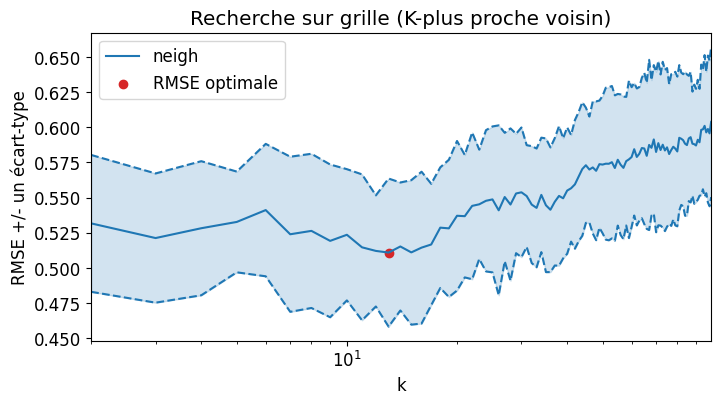

In [23]:
from sklearn import model_selection 

# Création des folds
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

# Définir la grille de valeurs de l'hyperparamètre k 
ks = range(2,100)

# Définir le modèle à évaluer
neigh = KNeighborsClassifier()

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(neigh, {'n_neighbors': ks}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='neg_root_mean_squared_error'
                                   )

# Utiliser la recherche sur grille
grid.fit(X_train_risk_vs_norisk, y_train_risk_vs_norisk)

plt.figure(figsize=(8, 4))

rmses = -grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE avec une échelle logarithmique pour les abscisses :
plt.semilogx(grid.cv_results_['param_n_neighbors'], rmses, 
             label="neigh", color='tab:blue')
plt.semilogx(grid.cv_results_['param_n_neighbors'], rmses + std_error, 
             color='tab:blue', linestyle='dashed')
plt.semilogx(grid.cv_results_['param_n_neighbors'], rmses - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(ks, (rmses + std_error), (rmses - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# afficher le meilleur score
plt.scatter(grid.best_params_['n_neighbors'], -grid.best_score_, 
           color='tab:red', label='RMSE optimale')
print(f"Le nombre optimal de plus proches voisins est {grid.best_params_['n_neighbors']}.")

# Mise en forme
plt.xlabel("k")
plt.ylabel("RMSE +/- un écart-type")
plt.xlim([ks[0], ks[-1]])
plt.title("Recherche sur grille (K-plus proche voisin)")
plt.legend(loc='best')
plt.show();

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.